# Аналитика в Яндекс.Афише

На основе данных от Яндекс.Афиши нужно определить направления оптимизации маркетинговых затрат.
Для анализа представлены следующие данные с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

## Этапы анализа

1. [Загрузка данных и подготовка к анализу](#one)
2. [Расчет метрик и построение отчетов](#two)
    * [Продукт](#two.1)
    * [Продажи](#two.2)
    * [Маркетинг](#two.3)
3. [Выводы](#three)

## 1. Загрузка данных и подготовка к анализу<a id="one"></a>

In [1]:
# Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from IPython.display import display

# Настройка отображения результатов
pd.set_option('precision', 3)
pd.set_option('display.max_columns', 50)
pd.options.mode.chained_assignment = None

# Открытие файлов с данными
visits = pd.read_csv('visits_log.csv')
orders = pd.read_csv('orders_log.csv')
costs = pd.read_csv('costs.csv')

In [2]:
# Ознакомление с данными
visits.info()
visits.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [3]:
orders.info()
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [4]:
costs.info()
costs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [5]:
# Проверка на наличие дубликатов
visits.duplicated().sum()

0

In [6]:
costs.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

In [8]:
# Переименовние колонок
visits.columns = ['device','end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

In [9]:
# Исправление форматов дат и времени
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M:%S')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M:%S')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M:%S')
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

In [10]:
# Получение общего представления о данных
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

In [11]:
visits['start_ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [12]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

***Описание данных***
    
Данные для анализа представлены в 3 таблицах. Для удобства дальнейшей работы наименования колонок в таблицах приведены к нижнему регистру, а также убраны пробелы.    
    
Таблица visits (лог сервера с информацией о посещениях сайта):
* uid — уникальный идентификатор пользователя
* device — категория устройства пользователя
* start_ts — дата и время начала сессии
* end_ts — дата и время окончания сессии
* source_id — идентификатор рекламного источника, из которого пришел пользователь
    
Таблица orders (информация о заказах):
* uid — уникальный id пользователя, который сделал заказ
* duy_ts — дата и время заказа
* revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день
    
В таблицах отсутсвуют дублирующие записи. В столбцах, содержащих информацию о датах событий, данные имеют тип "object". Содержимое этих столбцов переведено в понятный для Python формат даты и времени. 

## 2. Расчет метрик и построение отчетов <a id="two"></a>

### Продукт <a id="two.1"></a>

In [13]:
# Выделение года, месяца, недели и дня посещений
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [14]:
# Показатели активности пользователей
dau_all = visits.groupby('session_date').agg({'uid': 'nunique'})
wau_all = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
mau_all = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})

print(f'DAU (количество уникальных пользователей в день): {int(dau_all.mean())}')
print(f'WAU (количество уникальных пользователей в неделю): {int(wau_all.mean())}')
print(f'MAU (количество уникальных пользователей в месяц): {int(mau_all.mean())}') 

DAU (количество уникальных пользователей в день): 907
WAU (количество уникальных пользователей в неделю): 5716
MAU (количество уникальных пользователей в месяц): 23228


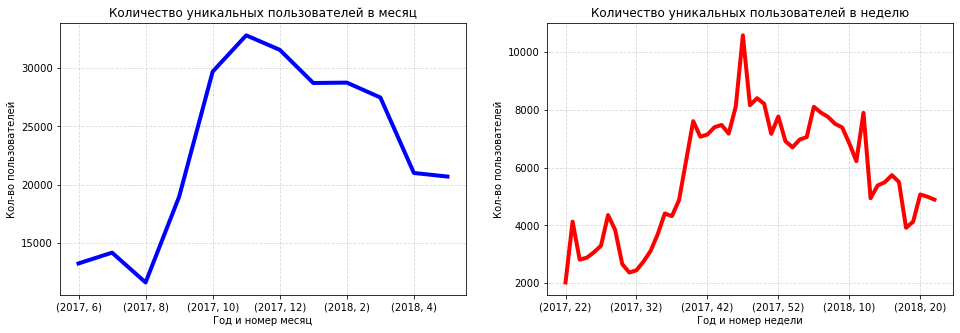

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))  
mau_all.plot(color='b', 
         ax=axs[0], 
         legend=False, 
         linewidth = 4, 
         title='Количество уникальных пользователей в месяц')
axs[0].grid(linestyle='--', alpha=0.5)
axs[0].set_xlabel("Год и номер месяц")
axs[0].set_ylabel("Кол-во пользователей")

wau_all.plot(color='r', 
         ax=axs[1], 
         legend=False, 
         linewidth = 4, 
         title='Количество уникальных пользователей в неделю')
axs[1].grid(linestyle='--', alpha=0.5)
axs[1].set_xlabel("Год и номер недели")
axs[1].set_ylabel("Кол-во пользователей")
plt.show()

In [16]:
# Функция для расчета пользовательской активности
def dau_wau_mau(df):
    dau = df.groupby('session_date').agg({'uid': 'nunique'})
    wau = df.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})
    mau = df.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
    print(f'DAU (количество уникальных пользователей в день): {int(dau.mean())}')
    print(f'WAU (количество уникальных пользователей в неделю): {int(wau.mean())}')
    print(f'MAU (количество уникальных пользователей в месяц): {int(mau.mean())}')
    
# Показатели активности пользователей в разрезе по устройствам
for device in visits['device'].unique():
    visits_device = visits[visits['device'] == device]
    print(f'_______________________________{device}_______________________________')
    dau_wau_mau(visits_device)

_______________________________touch_______________________________
DAU (количество уникальных пользователей в день): 252
WAU (количество уникальных пользователей в неделю): 1634
MAU (количество уникальных пользователей в месяц): 6825
_______________________________desktop_______________________________
DAU (количество уникальных пользователей в день): 659
WAU (количество уникальных пользователей в неделю): 4129
MAU (количество уникальных пользователей в месяц): 16724


In [17]:
# Показатели активности пользователей в разрезе по рекламным каналам
for source in visits['source_id'].unique():
    visits_sourse = visits[visits['source_id'] == source]
    print(f'_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №{source}_______________________________')
    dau_wau_mau(visits_sourse)

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №4_______________________________
DAU (количество уникальных пользователей в день): 275
WAU (количество уникальных пользователей в неделю): 1829
MAU (количество уникальных пользователей в месяц): 7765
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №2_______________________________
DAU (количество уникальных пользователей в день): 120
WAU (количество уникальных пользователей в неделю): 715
MAU (количество уникальных пользователей в месяц): 2752
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №5_______________________________
DAU (количество уникальных пользователей в день): 175
WAU (количество уникальных пользователей в неделю): 1167
MAU (количество уникальных пользователей в месяц): 5017
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №9_______________________________
DAU (количество уникальных пользователей в день): 36
WAU (количество уникальных пользователей в неделю): 238
MAU (количество уникальных пользователей в месяц): 987


In [18]:
# Sticky factor
sticky_mau = dau_all.mean() / mau_all.mean() * 100
sticky_wau = dau_all.mean() / wau_all.mean() * 100

display(sticky_mau)
display(sticky_wau)

uid    3.909
dtype: float64

uid    15.884
dtype: float64

In [19]:
# Расечт среднего кол-ва сессий на одного пользователя в день 
sessions_per_user = (visits
                     .groupby('session_date')
                     .agg({'uid': ['count','nunique']}))
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
display(sessions_per_user)

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.098
2017-06-02,658,608,1.082
2017-06-03,477,445,1.072
2017-06-04,510,476,1.071
2017-06-05,893,820,1.089
...,...,...,...
2018-05-27,672,620,1.084
2018-05-28,1156,1039,1.113
2018-05-29,1035,948,1.092


In [20]:
sessions_per_user['n_sessions'].mean()

987.3626373626373

In [21]:
sessions_per_user['sessions_per_user'].mean()

1.0821696440039723

In [22]:
# Расечт среднего кол-ва сессий на одного пользователя в месяц
sessions_per_user_month = (visits
                           .groupby(['session_year', 'session_month'])
                           .agg({'uid': ['count','nunique']}))
sessions_per_user_month.columns = ['n_sessions', 'n_users']
sessions_per_user_month['sessions_per_user'] = sessions_per_user_month['n_sessions'] / sessions_per_user_month['n_users']
display(sessions_per_user_month)

n_sessions  n_users  sessions_per_user
session_year session_month                                        
2017         6                   16505    13259              1.245
             7                   17828    14183              1.257
             8                   14355    11631              1.234
             9                   23907    18975              1.260
             10                  37903    29692              1.277
             11                  43969    32797              1.341
             12                  41983    31557              1.330
2018         1                   36939    28716              1.286
             2                   37182    28749              1.293
             3                   35679    27473              1.299
             4                   26515    21008              1.262
             5                   26635    20701              1.287

In [23]:
# Анализ ASL (средней продолжительности сессий)
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [24]:
visits['session_duration_sec'].describe()

count    359400.000
mean        643.506
std        1016.335
min           0.000
25%         120.000
50%         300.000
75%         840.000
max       84480.000
Name: session_duration_sec, dtype: float64

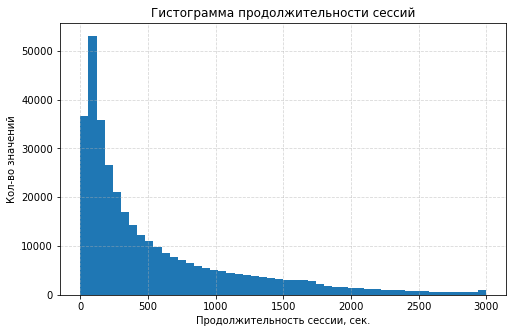

In [25]:
plt.title('Гистограмма продолжительности сессий')
visits['session_duration_sec'].hist(bins=50, range=(0,3000), figsize=(8,5))
plt.grid(linestyle='--', alpha=0.5)
plt.xlabel('Продолжительность сессии, сек.')
plt.ylabel("Кол-во значений")
plt.show()

In [26]:
visits['session_duration_sec'].mode()

0    60
dtype: int64

In [27]:
# Cредняя продолжительности сессий на разных устройствах
session_duration_grouped = (visits
                            .groupby('device')
                            .agg({'session_duration_sec': ['median', 'mean']})
                            .reset_index())
display(session_duration_grouped)

device session_duration_sec         
                         median     mean
0  desktop                  360  703.947
1    touch                  180  479.619

In [28]:
# Определение даты первого визита
first_session_date = visits.groupby('uid').agg({'session_date': 'min'})
first_session_date.columns = ['first_session_date']
visits = visits.join(first_session_date, on='uid')

In [29]:
# Расчет «месяца жизни»
visits['first_session_month'] = visits['first_session_date'].astype('datetime64[M]')
visits['session_month2'] = visits['session_date'].astype('datetime64[M]')
visits['cohort_lifetime'] = (((visits['session_month2']
                             - visits['first_session_month'])
                             / np.timedelta64(1, 'M'))
                             .round().astype('int'))

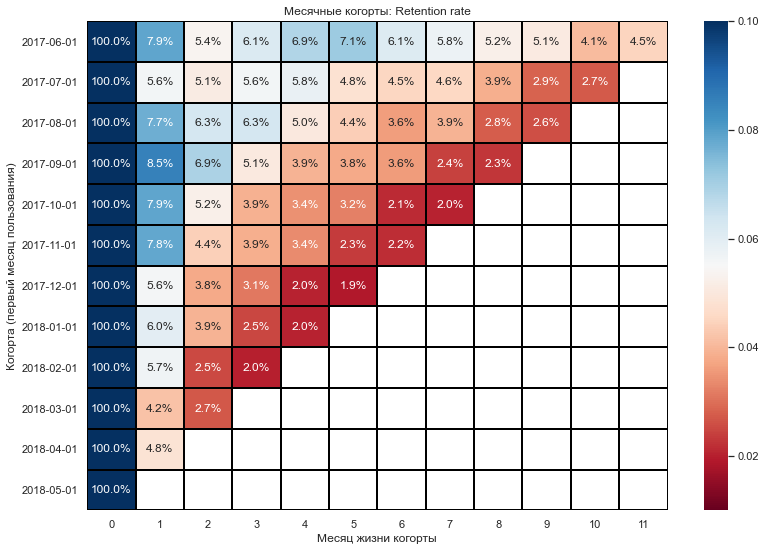

In [30]:
# Построение когорт
cohorts = (visits
           .groupby(['first_session_month','cohort_lifetime'])
           .agg({'uid':'nunique'})
           .reset_index())

# Исходное количество пользователей в когортах
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_session_month')

# Расчет Retention Rate
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_session_month'] = cohorts['first_session_month'].astype('str') # тип данных изменен для красоты графиков
retention_pivot = cohorts.pivot_table(index='first_session_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Месячные когорты: Retention rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', cmap="RdBu", vmin=0.01, vmax=0.1, linewidths=1, linecolor='black')
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Когорта (первый месяц пользования)')
plt.show()

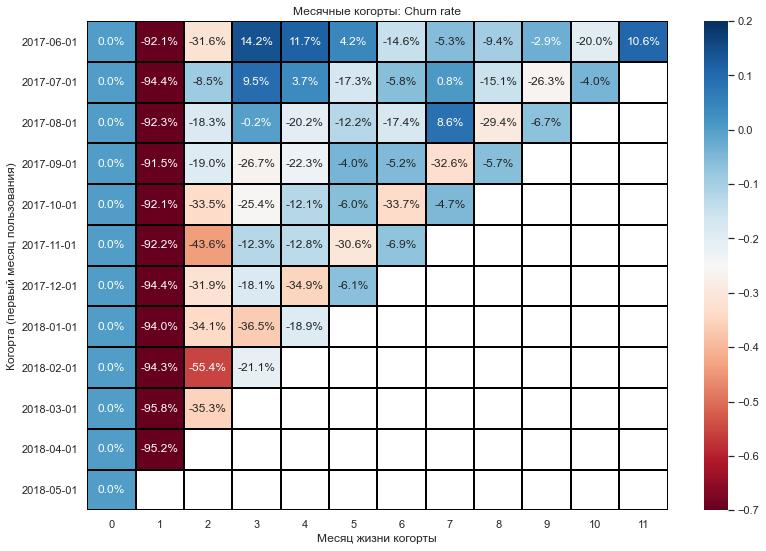

In [31]:
# Расчет Churn Rate
cohorts['churn_rate'] = cohorts.groupby(['first_session_month'])['uid'].pct_change()
churn_pivot = cohorts.pivot_table(index='first_session_month',
                                  columns='cohort_lifetime',
                                  values='churn_rate',
                                  aggfunc='sum')

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Месячные когорты: Churn rate')
sns.heatmap(churn_pivot, 
            annot=True, 
            fmt='.1%', 
            cmap="RdBu", 
            vmin=-0.7, 
            vmax=0.2, 
            linewidths=1, 
            linecolor='black')
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Когорта (первый месяц пользования)')
plt.show()

_______________________________touch_______________________________


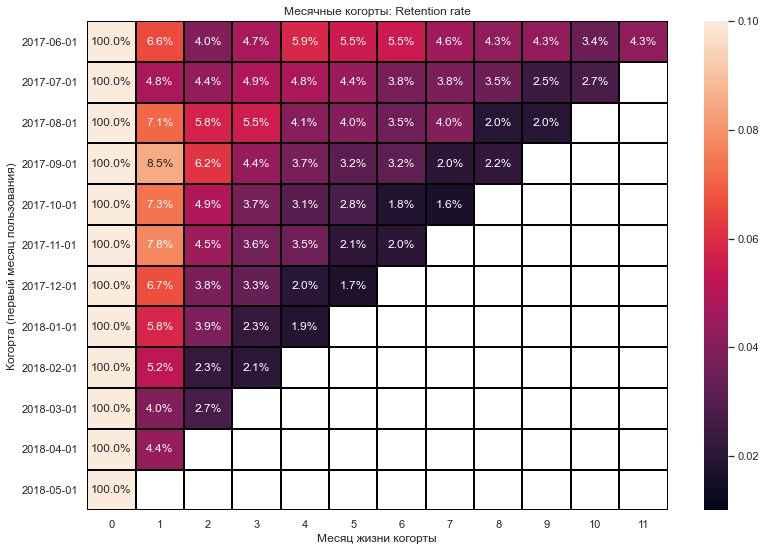

_______________________________desktop_______________________________


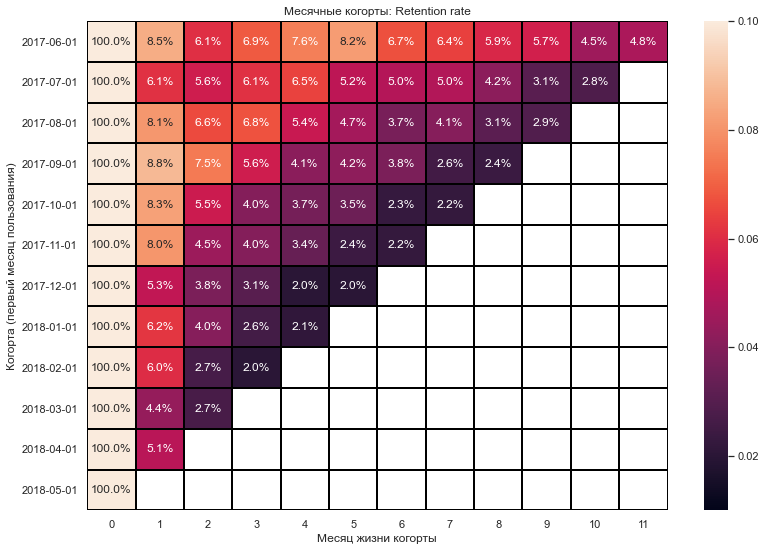

In [32]:
# Функция для расчета Retention Rate
def retention(df):
    coh = (df
           .groupby(['first_session_month','cohort_lifetime'])
           .agg({'uid':'nunique'})
           .reset_index())
    # Исходное количество пользователей в когортах
    initial_users = coh[coh['cohort_lifetime'] == 0][['first_session_month','uid']]
    initial_users = initial_users.rename(columns={'uid':'cohort_users'})
    coh = coh.merge(initial_users,on='first_session_month')
    # Расчет Retention Rate
    coh['retention'] = coh['uid']/coh['cohort_users']
    coh['first_session_month'] = coh['first_session_month'].astype('str')
    retention = coh.pivot_table(index='first_session_month',
                                columns='cohort_lifetime',
                                values='retention',
                                aggfunc='sum')
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Месячные когорты: Retention rate')
    sns.heatmap(retention, annot=True, fmt='.1%', vmin=0.01, vmax=0.1, linewidths=1, linecolor='black')
    plt.xlabel('Месяц жизни когорты')
    plt.ylabel('Когорта (первый месяц пользования)')
    plt.show()
 
# Retention Rate в разрезе по устройствам
for device in visits['device'].unique():
    visits_device = visits[visits['device'] == device]
    print(f'_______________________________{device}_______________________________')
    retention(visits_device)

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №4_______________________________


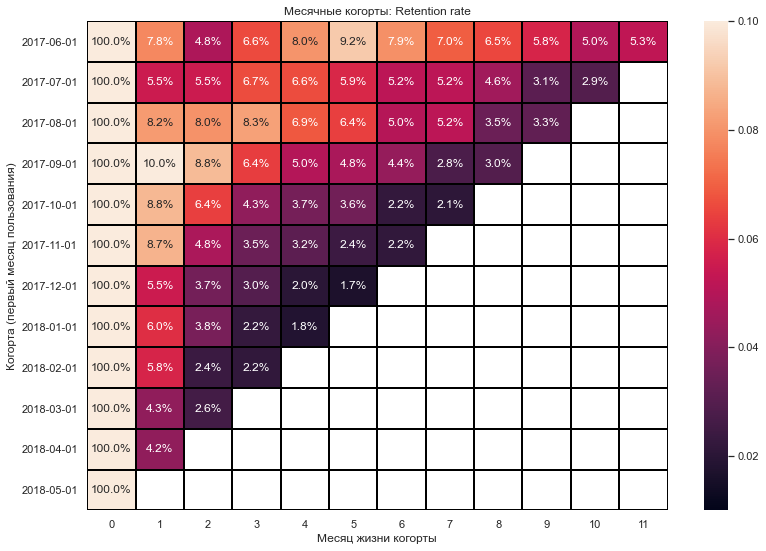

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №2_______________________________


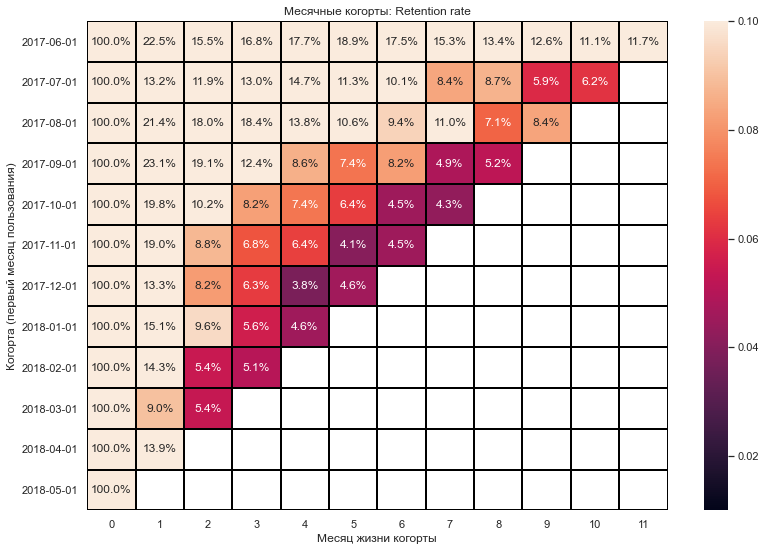

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №5_______________________________


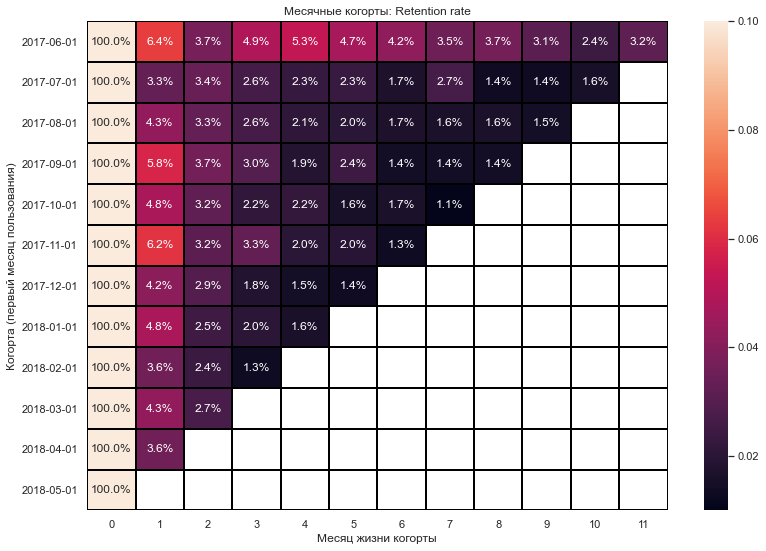

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №9_______________________________


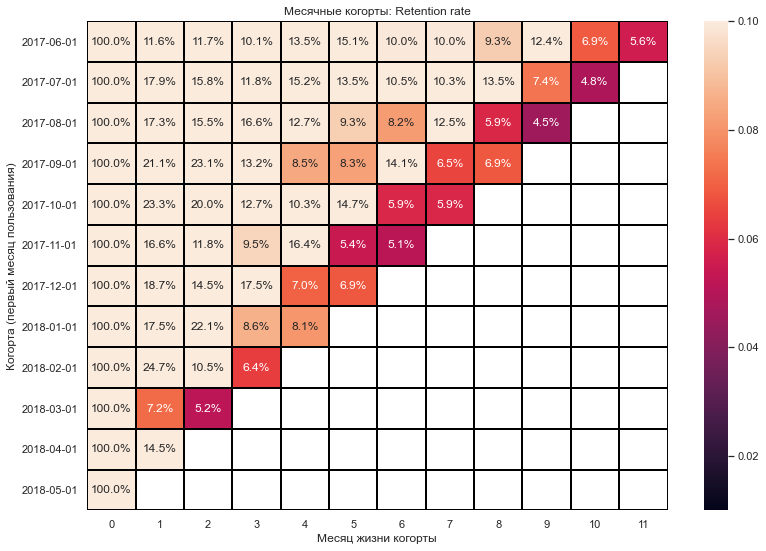

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №3_______________________________


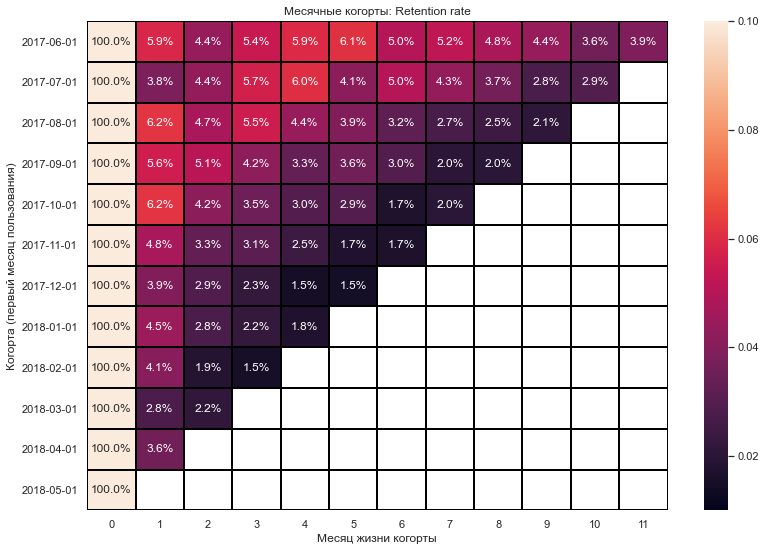

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №1_______________________________


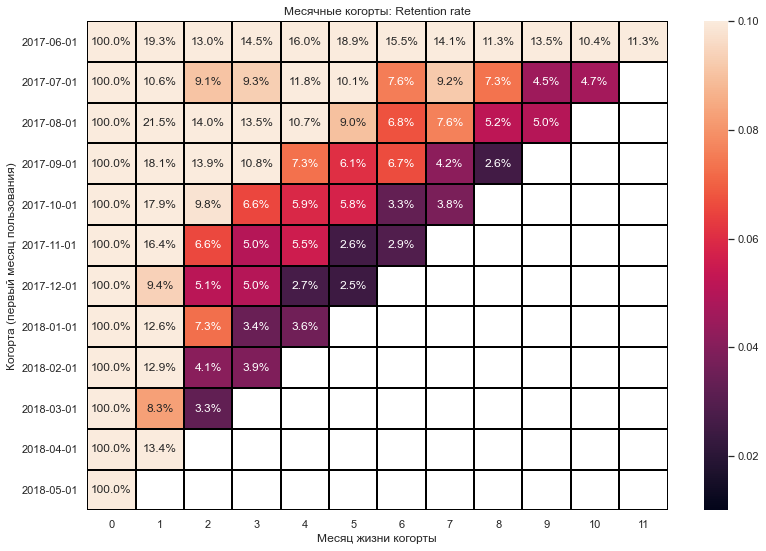

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №10_______________________________


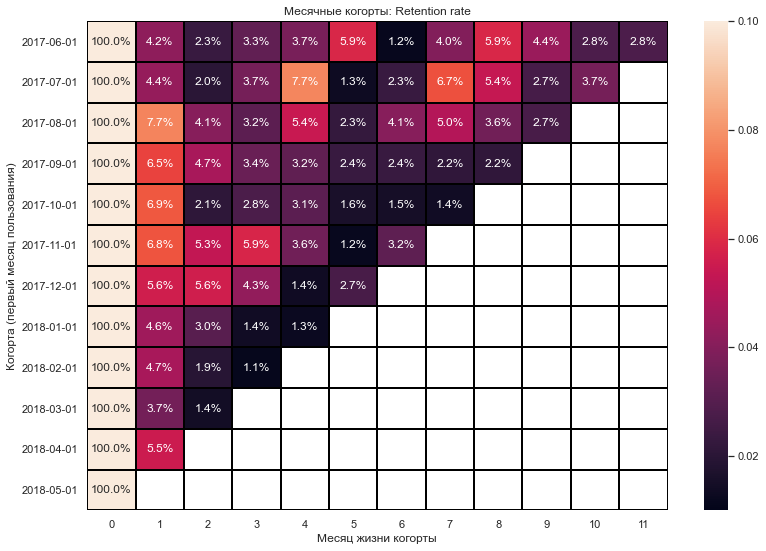

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №7_______________________________


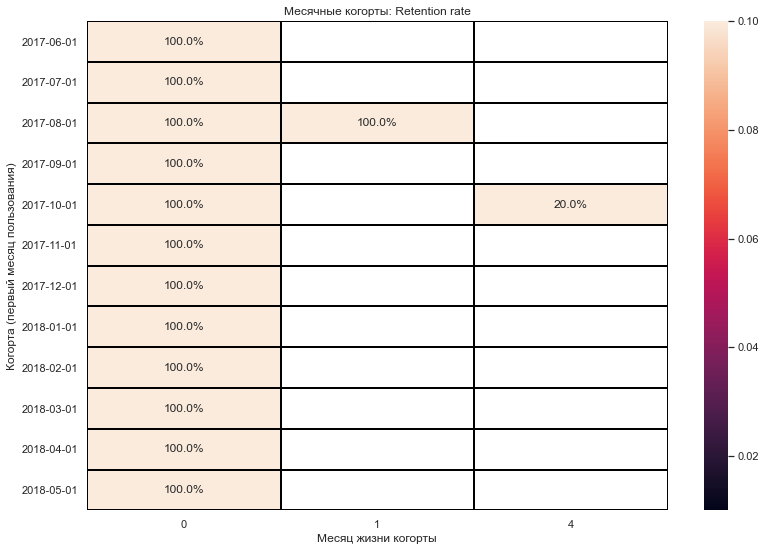

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №6_______________________________


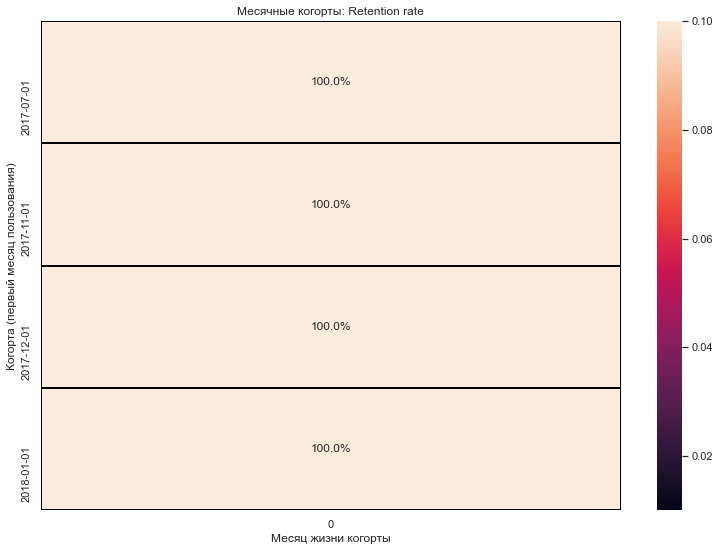

In [33]:
# Retention Rate в разрезе по рекламным источникам
for source in visits['source_id'].unique():
    visits_sourse = visits[visits['source_id'] == source]
    print(f'_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №{source}_______________________________')
    retention(visits_sourse)

* За исследуемый период количество уникальных пользователей в день в среднем составляло 907 человек, в неделю - 5,7 тыс. человек, в месяц - 23,2 тыс., при этом количество уникальных пользователей значительно возрастает с августа по ноябрь, что может быть связано с покупкой билетов на новогодние мероприятия.
    
* Как правило, для подключения к сервису пользователи чаще используют компьютер (количество уникальных пользователей в день, подключающихся посредством компьютера, в 2,5 раза превышает соответствующее значение для мобильных устройств).
    
* В среднем в день фиксируется 987 сессий, т.е. чуть более 1.08 сессии на одного уникального пользователя.
    
* Одна сессия длится в среднем 300 сек (или 5 минут), однако наибольшее число составляют сессии продолжительность 60 сек (1 минута). Стоит отметить, что продолжительность сессий с компьютеров, как правило, в 2 раза дольше, что с мобильных устройств.
    
* На второй месяц сервис теряет более 90% пользователей. Как правило, около 6-7% возвращаются на сервис к новому году (ближе к октябрю-ноябрю). Ближе к лету (в мае) коэффициент удержания падает почти во всех когорта, что может быть связано с началом сезона отпусков. 
    
* Больше всего уникальных пользователей привлекают рекламные источники №2, №3, №4 и №5. При этом пользователи из источников №1, №2, №9 и №4 чаще возвращаются на сервис.

### Продажи  <a id="two.2"></a>

In [34]:
# Определение даты первой покупки
orders['buy_day'] = orders['buy_ts'].dt.date
first_orders_date = (orders
                     .groupby('uid')
                     .agg({'buy_day': 'min'}))
first_orders_date.columns = ['first_buy_date']
display(first_orders_date.head(10))

,first_buy_date
uid,
313578113262317,2018-01-03
1575281904278712,2017-06-03
2429014661409475,2017-10-11
2464366381792757,2018-01-28
2551852515556206,2017-11-24
3077748354309989,2018-03-03
3605148382144603,2017-09-21
3753586865891862,2018-03-03
4808417689019433,2018-01-09


In [35]:
# Рекламный источник и устройство пользователя
first_orders_visits_date = first_orders_date.merge(first_session_date, on='uid', how='left')
first_orders_source = first_orders_visits_date.merge(visits[['uid', 'session_date', 'first_session_date', 'source_id', 'device']], 
                                                     left_on=['uid', 'first_session_date'],
                                                     right_on=['uid', 'session_date'], 
                                                     how='left').drop_duplicates()
first_orders_source = first_orders_source.drop(['session_date', 'first_session_date_y'] ,axis=1)
display(first_orders_source.head(10))

,uid,first_buy_date,first_session_date_x,source_id,device
0,313578113262317,2018-01-03,2017-09-18,2,desktop
1,1575281904278712,2017-06-03,2017-06-03,10,touch
3,2429014661409475,2017-10-11,2017-10-11,3,desktop
4,2464366381792757,2018-01-28,2018-01-27,5,desktop
5,2551852515556206,2017-11-24,2017-11-24,5,desktop
7,3077748354309989,2018-03-03,2018-03-03,3,touch
8,3605148382144603,2017-09-21,2017-08-15,2,desktop
9,3753586865891862,2018-03-03,2018-03-03,4,desktop
10,4808417689019433,2018-01-09,2018-01-09,4,desktop
11,4992223027560440,2018-04-04,2018-04-04,5,touch


In [36]:
orders = orders.merge(first_orders_source[['uid', 'source_id', 'device']], on = 'uid', how ='left')

In [37]:
# Расчет времени между первым посещением и первой покупкой
visits = visits.merge(first_orders_date, on = 'uid', how ='left')
visits['buy_delta'] = ((visits['first_buy_date'] - visits['first_session_date'])
                       / np.timedelta64(1, 'D'))
first_time = (visits
              .pivot_table(index='uid', values=['first_session_month', 'buy_delta'], aggfunc='first')
              .reset_index())
display(first_time.head())

,uid,buy_delta,first_session_month
0,11863502262781,NaN,2018-03-01
1,49537067089222,NaN,2018-02-01
2,297729379853735,NaN,2017-06-01
3,313578113262317,107.0,2017-09-01
4,325320750514679,NaN,2017-09-01


In [38]:
# Доля покупателей
first_time['buy_delta'].notnull().mean()

0.16006994815246595

In [39]:
# Анализ периода между первым посещением и пeрвой покупкой
first_time['buy_delta'].describe()

count    36523.000
mean        16.896
std         47.071
min          0.000
25%          0.000
50%          0.000
75%          2.000
max        363.000
Name: buy_delta, dtype: float64

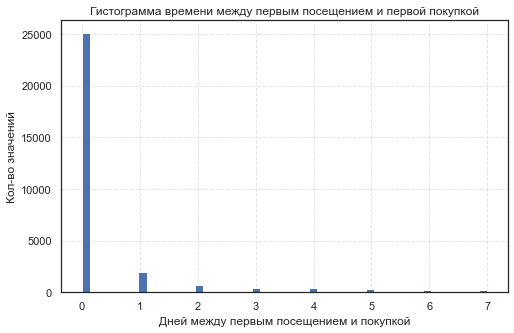

In [40]:
plt.title('Гистограмма времени между первым посещением и первой покупкой')
first_time['buy_delta'].hist(bins=50, range=(0, 7), figsize=(8,5))
plt.grid(linestyle='--', alpha=0.5)
plt.xlabel('Дней между первым посещением и покупкой')
plt.ylabel("Кол-во значений")
plt.show()

In [41]:
first_time_grouped1 = (first_time
                       .groupby('first_session_month')
                       .agg({'buy_delta': ['median', 'mean']})
                       .reset_index())
first_time_grouped1.columns = ['first_session_month', 'buy_delta_meadian', 'buy_delta_mean']

first_time_grouped2 = (first_time
                       .groupby('first_session_month')['buy_delta']
                       .apply(lambda x: x.notnull().mean())
                       .reset_index())
first_time_grouped2.columns = ['first_session_month', 'buyers_ratio']

first_time_grouped = first_time_grouped1.merge(first_time_grouped2, on='first_session_month')
display(first_time_grouped)

,first_session_month,buy_delta_meadian,buy_delta_mean,buyers_ratio
0,2017-06-01,0.0,46.622,0.220
1,2017-07-01,0.0,40.425,0.187
2,2017-08-01,0.0,33.390,0.169
3,2017-09-01,0.0,24.940,0.183
4,2017-10-01,0.0,17.019,0.180
5,2017-11-01,0.0,15.647,0.156
6,2017-12-01,0.0,10.806,0.161
7,2018-01-01,0.0,8.377,0.138
8,2018-02-01,0.0,5.340,0.144
9,2018-03-01,0.0,3.054,0.138


In [42]:
# Расчет кол-ва покупок за период на одного покупателя
buys = orders.groupby('uid').agg({'buy_ts': 'count'})
buys['buy_ts'].describe()

count    36523.000
mean         1.524
std          4.594
min          1.000
25%          1.000
50%          1.000
75%          1.000
max        478.000
Name: buy_ts, dtype: float64

In [43]:
buys[buys['buy_ts'] > 100]

,buy_ts
uid,
2372603640946287896,124
3263486045884611639,262
3501596628378158474,150
3644482766749211722,478
5139615590553126732,150
5539673724080479777,101
6166747268563050393,234
6731421022966725351,183
6948781160947906362,115


In [44]:
# Расчет среднего чека
orders['revenue'].describe()

count    55666.000
mean         5.012
std         21.087
min          0.000
25%          1.220
50%          2.570
75%          4.890
max       2633.280
Name: revenue, dtype: float64

In [45]:
orders[orders['revenue'] == 0].count()

buy_ts       61
revenue      61
uid          61
buy_day      61
source_id    61
device       61
dtype: int64

In [46]:
# Аналииз среднего чека по устройствам
check_by_device = (orders
                   .groupby('device')
                   .agg({'revenue': 'median'})
                   .reset_index())
display(check_by_device)

,device,revenue
0,desktop,2.69
1,touch,2.44


In [47]:
# Аналииз среднего чек по рекламным источникам
check_by_source = (orders
                   .groupby('source_id')
                   .agg({'revenue': 'median'})
                   .reset_index()
                   .sort_values(by='revenue', ascending=False))
display(check_by_source)

,source_id,revenue
0,1,2.930
1,2,2.810
4,5,2.810
3,4,2.575
2,3,2.440
6,9,2.320
7,10,1.830
5,7,1.220


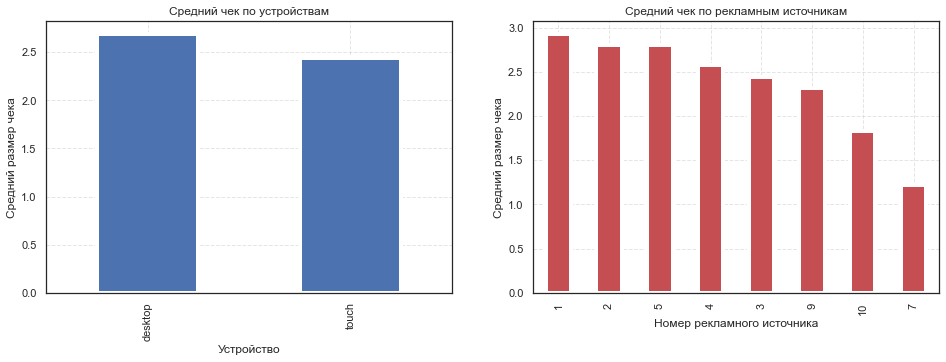

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))  
check_by_device.plot(x='device',
                     y='revenue',
                     kind='bar', 
                     color='b', 
                     ax=axs[0], 
                     legend=False, 
                     linewidth = 4, 
                     title='Средний чек по устройствам')
axs[0].grid(linestyle='--', alpha=0.5)
plt.xticks(rotation='vertical')
axs[0].set_xlabel("Устройство")
axs[0].set_ylabel("Средний размер чека")

check_by_source.plot(x='source_id',
                      y='revenue',
                      kind='bar',
                      color='r', 
                      ax=axs[1], 
                      legend=False, 
                      linewidth = 4, 
                      title='Средний чек по рекламным источникам')
axs[1].grid(linestyle='--', alpha=0.5)
axs[1].set_xlabel("Номер рекламного источника")
axs[1].set_ylabel("Средний размер чека")

plt.show()

In [49]:
# Аналииз выручки и среднего чека по месяцам
orders['buy_month'] = orders['buy_ts'].astype('datetime64[M]')
revenue_by_month = (orders
                    .groupby('buy_month')
                    .agg({'revenue': ['sum', 'median', 'mean']})
                    .reset_index())
revenue_by_month.columns = ['month','revenue_sum', 'revenue_median', 'revenue_mean']
display(revenue_by_month)

,month,revenue_sum,revenue_median,revenue_mean
0,2017-06-01,11210.64,2.44,4.305
1,2017-07-01,13850.54,3.30,5.333
2,2017-08-01,9689.51,2.81,4.916
3,2017-09-01,20242.36,2.44,5.466
4,2017-10-01,31163.33,2.46,4.989
5,2017-11-01,29986.26,2.44,4.745
6,2017-12-01,38995.18,2.69,5.694
7,2018-01-01,21155.50,2.44,4.079
8,2018-02-01,27576.28,2.69,4.778
9,2018-03-01,31890.08,2.44,5.371


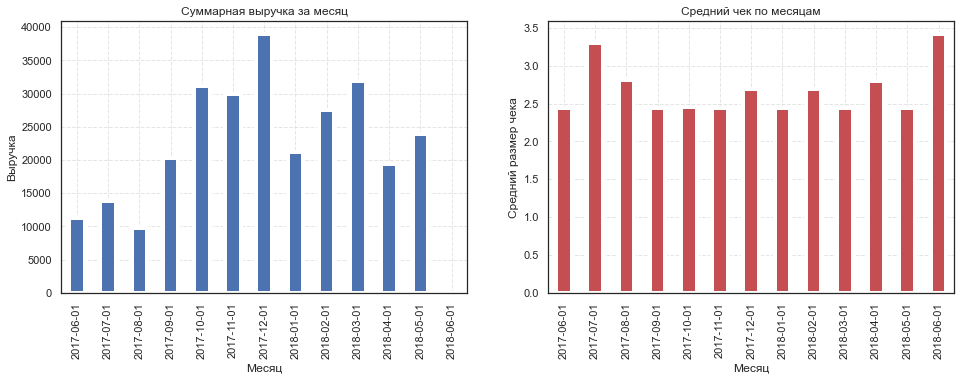

In [50]:
revenue_by_month['month'] = revenue_by_month['month'].astype('str') # тип данных изменен для красоты графиков
fig, axs = plt.subplots(1, 2, figsize=(16,5))  
revenue_by_month.plot(x='month',
                      y='revenue_sum',
                      kind='bar', 
                      color='b', 
                      ax=axs[0], 
                      legend=False, 
                      linewidth = 4, 
                      title='Суммарная выручка за месяц')
axs[0].grid(linestyle='--', alpha=0.5)
plt.xticks(rotation='vertical')
axs[0].set_xlabel("Месяц")
axs[0].set_ylabel("Выручка")

revenue_by_month.plot(x='month',
                      y='revenue_median',
                      kind='bar',
                      color='r', 
                      ax=axs[1], 
                      legend=False, 
                      linewidth = 4, 
                      title='Средний чек по месяцам')
axs[1].grid(linestyle='--', alpha=0.5)
axs[1].set_xlabel("Месяц")
axs[1].set_ylabel("Средний размер чека")

plt.show()

In [51]:
# Построение когорт
# Определение месяца первой покупки
orders = orders.merge(first_orders_date, on = 'uid', how ='left')
orders['first_buy_month'] = orders['first_buy_date'].astype('datetime64[M]')
cohorts_orders = orders.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()

# Количество пользователей в когортах
cohort_sizes = orders.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_buy_month', 'n_buyers']
cohorts_orders = cohorts_orders.merge(cohort_sizes, on='first_buy_month')

# Расчет «месяца жизни»
cohorts_orders['cohort_lifetime'] = (((cohorts_orders['buy_month']
                                       - cohorts_orders['first_buy_month'])
                                      / np.timedelta64(1, 'M'))
                                     .round().astype('int'))

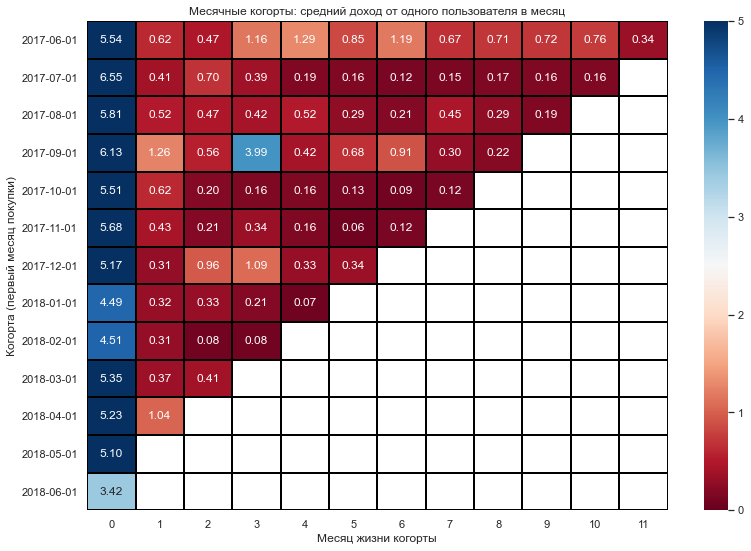

In [52]:
# Средний доход от одного пользователся из разных когорт в месяц
cohorts_orders['rev_mean'] = cohorts_orders['revenue'] / cohorts_orders['n_buyers']
cohorts_orders['first_buy_month2'] = cohorts_orders['first_buy_month'].astype('str')
output = (cohorts_orders
          .pivot_table(
              index='first_buy_month2', 
              columns='cohort_lifetime', 
              values='rev_mean', 
              aggfunc='mean')
          .round(decimals=2))

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Месячные когорты: средний доход от одного пользователя в месяц')
sns.heatmap(output, 
            annot=True, 
            fmt='.2f', 
            cmap="RdBu", 
            vmin=0, 
            vmax=5, 
            linewidths=1, 
            linecolor='black')
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Когорта (первый месяц покупки)')
plt.show()

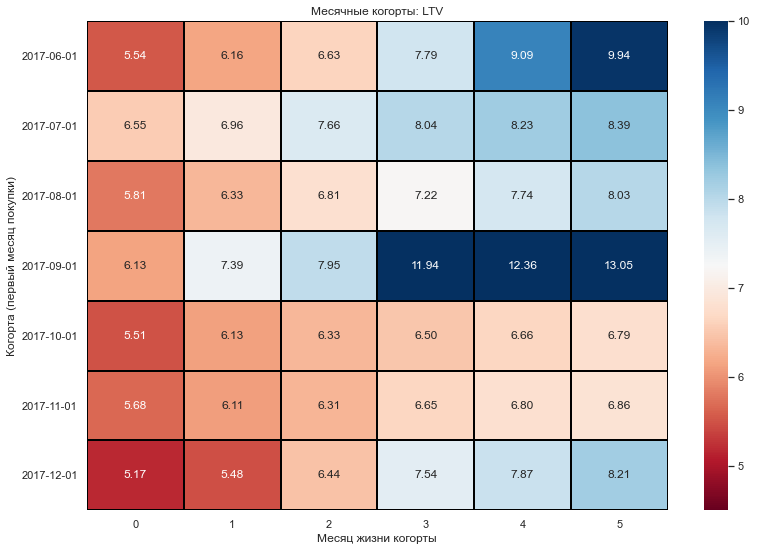

In [53]:
# Расчет LTV
cohorts_orders_LTV = cohorts_orders.query('first_buy_month < "2018-01-01" and cohort_lifetime < 6')
output_LTV = cohorts_orders_LTV.pivot_table(index='first_buy_month2', 
                                         columns='cohort_lifetime', 
                                         values='rev_mean', 
                                         aggfunc='mean')
output_LTV = output_LTV.cumsum(axis=1)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Месячные когорты: LTV')
sns.heatmap(output_LTV, 
            annot=True, 
            fmt='.2f', 
            cmap="RdBu", 
            vmin=4.5, 
            vmax=10, 
            linewidths=1, 
            linecolor='black')
plt.xlabel('Месяц жизни когорты')
plt.yticks(rotation=0)
plt.ylabel('Когорта (первый месяц покупки)')
plt.show()

In [54]:
output_LTV.mean(axis=0)

cohort_lifetime
0    5.770
1    6.367
2    6.876
3    7.954
4    8.393
5    8.752
dtype: float64

_______________________________desktop_______________________________


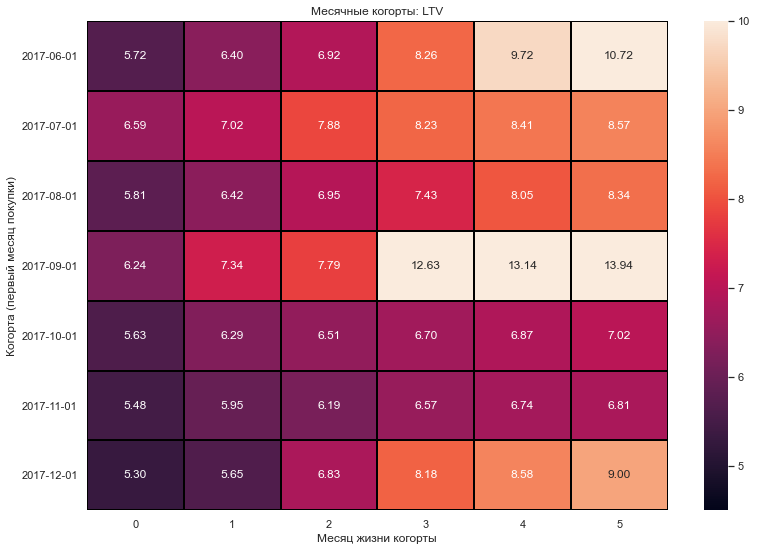

_______________________________touch_______________________________


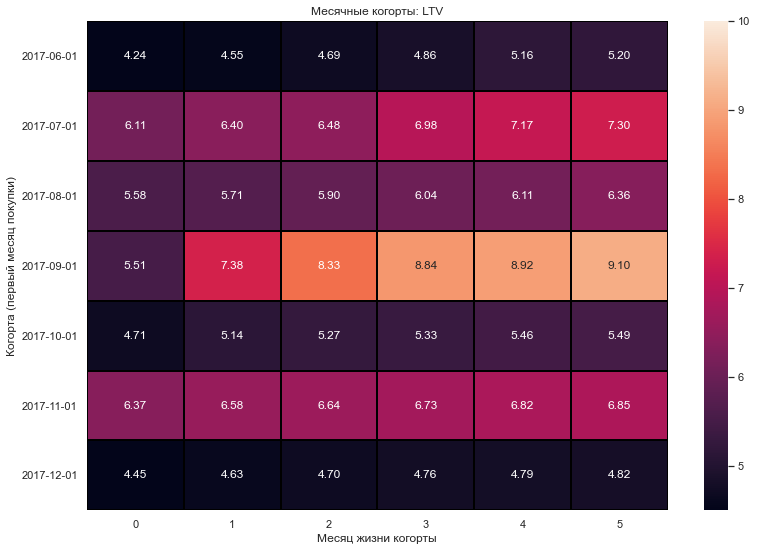

In [55]:
# Функция для расчета LTV
def ltv(df):
    coh = df.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
    # Количество пользователей в когортах
    coh_sizes = df.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
    coh_sizes.columns = ['first_buy_month', 'n_buyers']
    coh = coh.merge(coh_sizes, on='first_buy_month')
    # Расчет «месяца жизни»
    coh['cohort_lifetime'] = (((coh['buy_month'] - coh['first_buy_month'])
                               / np.timedelta64(1, 'M'))
                              .round().astype('int'))
    coh['rev_mean'] = coh['revenue'] / coh['n_buyers']
    coh['first_buy_month2'] = coh['first_buy_month'].astype('str')
    coh_LTV = coh.query('first_buy_month < "2018-01-01" and cohort_lifetime < 6')
    out_LTV = coh_LTV.pivot_table(index='first_buy_month2', 
                                  columns='cohort_lifetime', 
                                  values='rev_mean', 
                                  aggfunc='mean')
    out_LTV = out_LTV.cumsum(axis=1)
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Месячные когорты: LTV')
    sns.heatmap(out_LTV, 
                annot=True, 
                fmt='.2f', 
                vmin=4.5, 
                vmax=10, 
                linewidths=1, 
                linecolor='black')
    plt.xlabel('Месяц жизни когорты')
    plt.yticks(rotation=0)
    plt.ylabel('Когорта (первый месяц покупки)')
    plt.show()
    
# LTV в разрезе по устройствам
for device in orders['device'].unique():
    orders_device = orders[orders['device'] == device]
    print(f'_______________________________{device}_______________________________')
    ltv(orders_device)    

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №1_______________________________


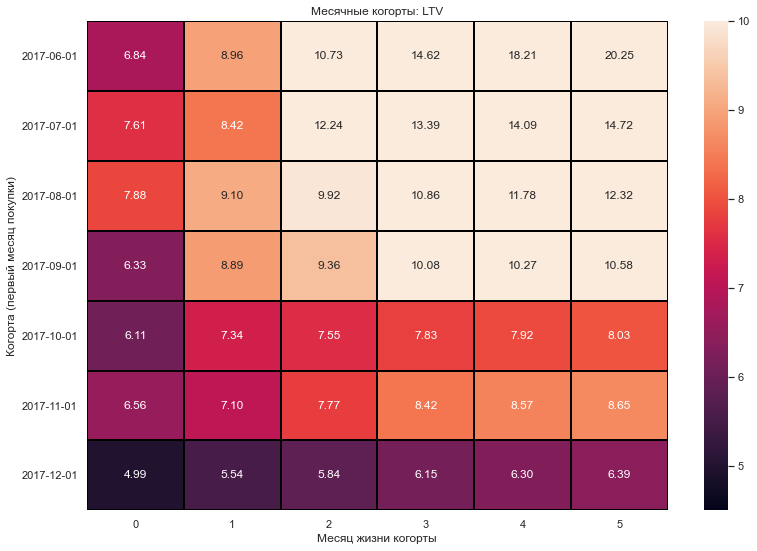

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №2_______________________________


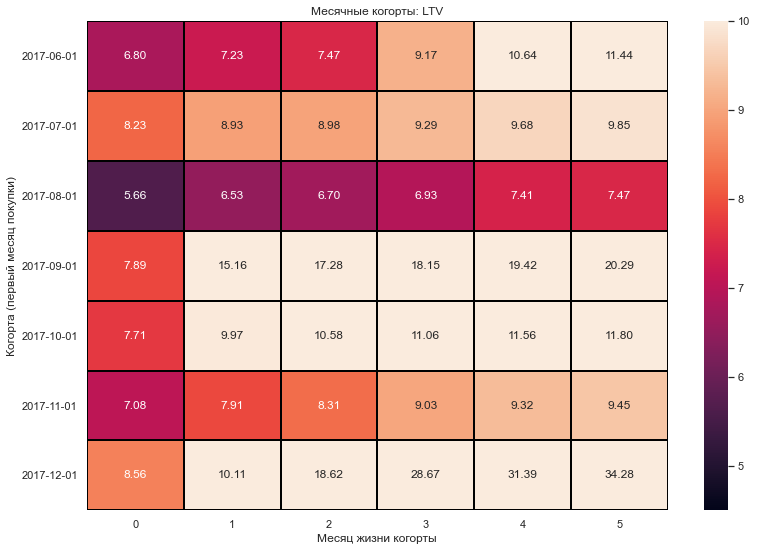

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №3_______________________________


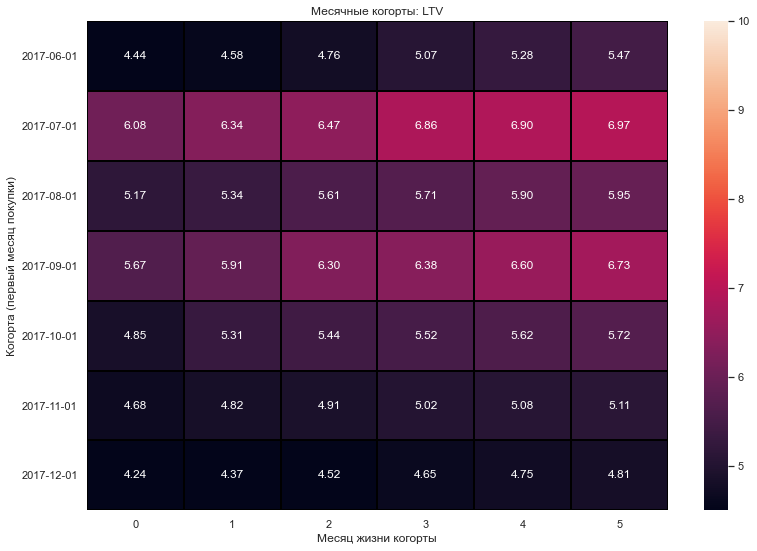

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №5_______________________________


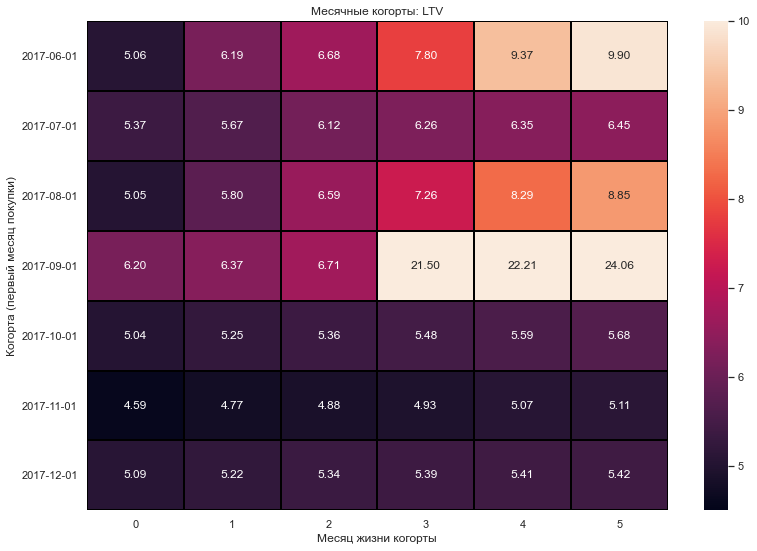

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №4_______________________________


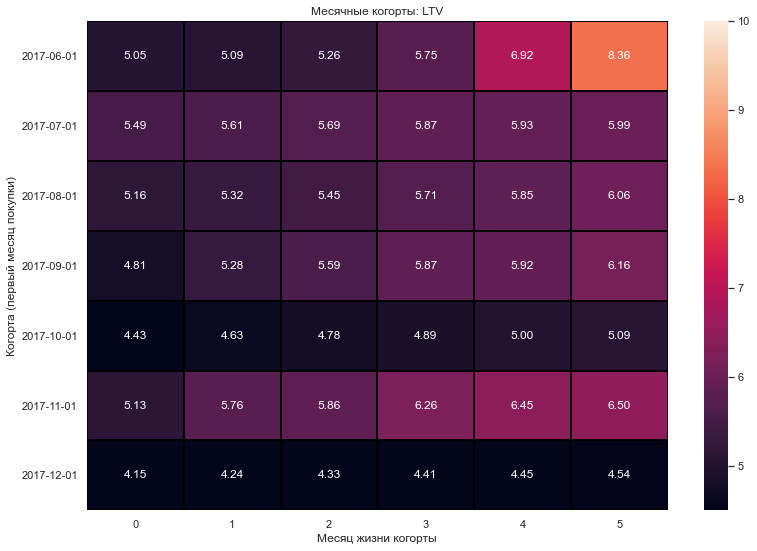

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №9_______________________________


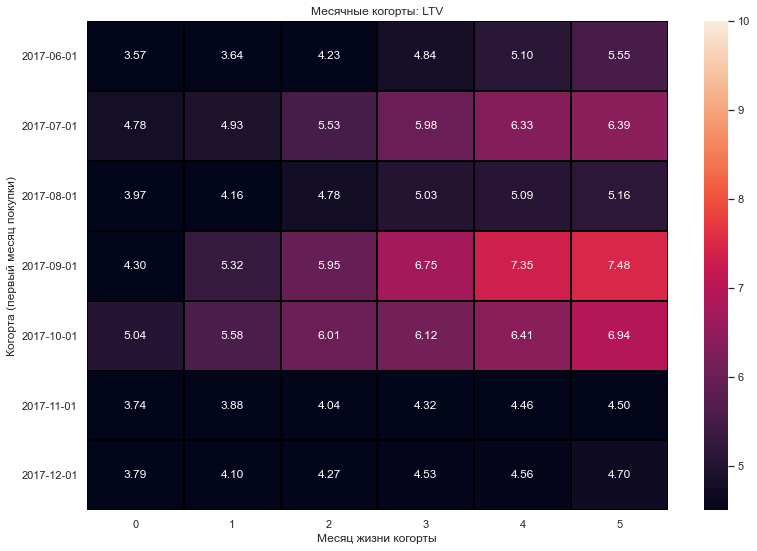

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №10_______________________________


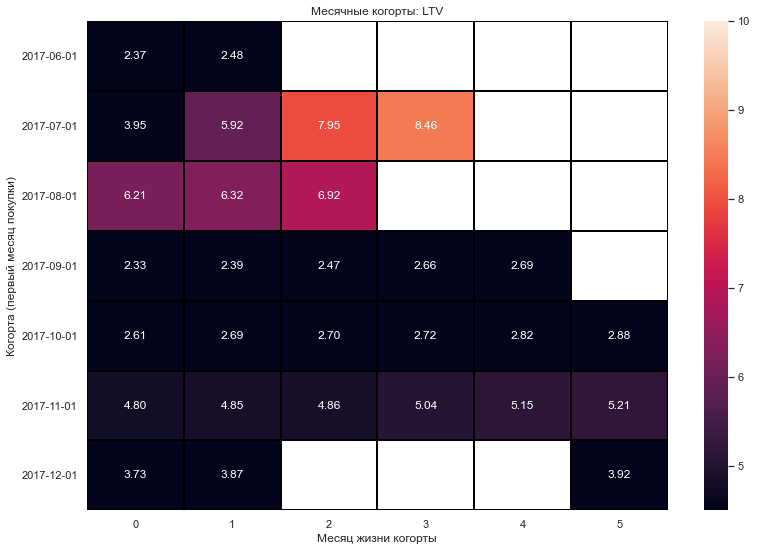

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №7_______________________________


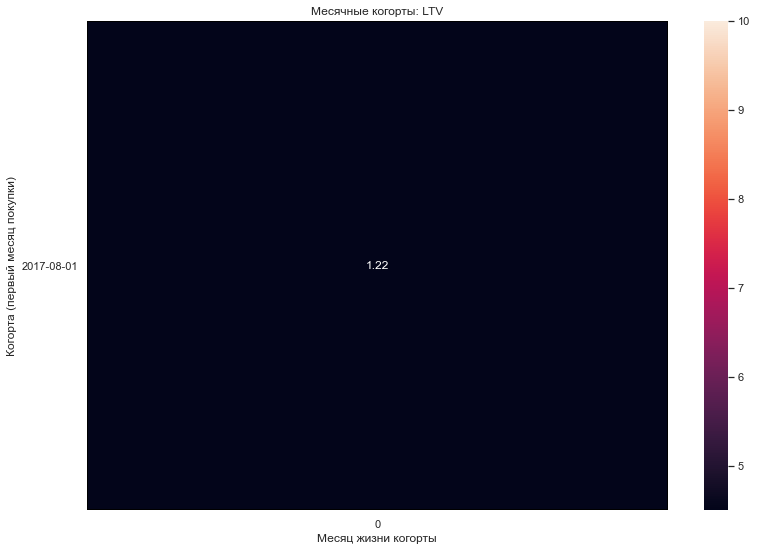

In [56]:
# LTV в разрезе по рекламным источникам
for source in orders['source_id'].unique():
    orders_sourse = orders[orders['source_id'] == source]
    print(f'_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №{source}_______________________________')
    ltv(orders_sourse)

* Около 16% посетителей совершают покупку. При этом первая покупка вне зависимости от месяца, как правило, совершается в день первого посещения. 
    
*  Подавляющее большинство пользователей совершает за год не более 1 покупки, при этом есть категория пользователей (12 пользователей), совершивших более 100 покупок.
    
* Суммарная выручка от покупок достигает пика к январю (36,3 тыс. руб.). Средняя же выручка сервиса с одной покупки относительно стабильна по месяцам и составляет 2,5 руб. 
    
* Для ответа на вопрос "Сколько пользователь приносит в среднем со всех своих покупок (LTV)" использован когортный анализ. С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. Для сравнимости в качестве "периода жизни" когорты было принято 6 месяцев (данный период позволяет отсечь при расчете не так много когорт). Так к концу 6 месяца пользователи когорт в среднем приносят 7,96 руб. Примечательно является сентябрьская когорта, где этот показатель достигает 12,3 руб.
    
* Средний чек покупателей, пользующихся компьютерами для доступа к сервису, на 0,25 руб. выше покупателей, пользующихся мобильными устройствами. LTV таких пользователей за 6 месяцев также выше.

### Маркетинг  <a id="two.3"></a>

In [57]:
# Объем затрат на маркетинг
costs['month_dt'] = costs['dt'].astype('datetime64[M]')
costs['month'] = costs['month_dt'].astype('str')
costs['costs'].describe()

count    2542.000
mean      129.477
std       156.297
min         0.540
25%        21.945
50%        77.295
75%       170.065
max      1788.280
Name: costs, dtype: float64

In [58]:
costs['costs'].sum()

329131.62

_______________________________costs_by_month_______________________________


,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


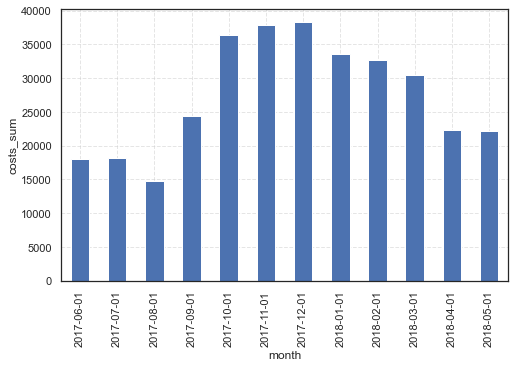

_______________________________costs_by_source_id_______________________________


,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


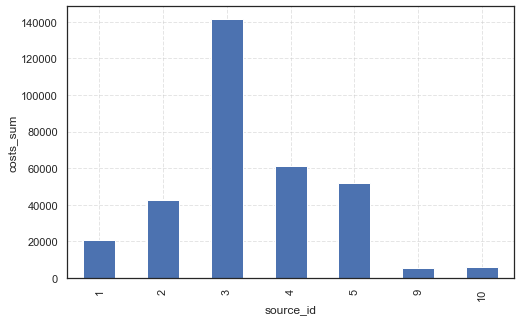

In [59]:
for column_name in costs[['month', 'source_id']]:
    column = costs[column_name]
    print(f'_______________________________costs_by_{column_name}_______________________________')
    pivot = costs.groupby(column_name).agg({'costs': 'sum'}).reset_index()
    display(pivot)
    pivot.plot(x=column_name, y='costs', kind='bar', color='b', figsize=(8,5), legend=False)
    plt.grid(linestyle='--', alpha=0.5)
    plt.xlabel(column_name)
    plt.ylabel("costs_sum")
    plt.show()

In [60]:
# Количество уникальных покупателей из каждого источника
buyers_by_sourse = first_orders_source.groupby('source_id').agg({'uid': 'nunique'}).reset_index()
display(buyers_by_sourse.head(10))

,source_id,uid
0,1,4044
1,2,3893
2,3,10712
3,4,10546
4,5,7688
5,7,1
6,9,1106
7,10,1370


In [61]:
# Объединение с данными по затратам на каждый источник и расечт стоимости привлечения одного покупателя из каждого источника
source_costs = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
orders_source_costs = source_costs.merge(buyers_by_sourse, on='source_id')
orders_source_costs['costs_per_uid'] = orders_source_costs['costs'] / orders_source_costs['uid']
orders_source_costs

,source_id,costs,uid,costs_per_uid
0,1,20833.27,4044,5.152
1,2,42806.04,3893,10.996
2,3,141321.63,10712,13.193
3,4,61073.60,10546,5.791
4,5,51757.10,7688,6.732
5,9,5517.49,1106,4.989
6,10,5822.49,1370,4.250


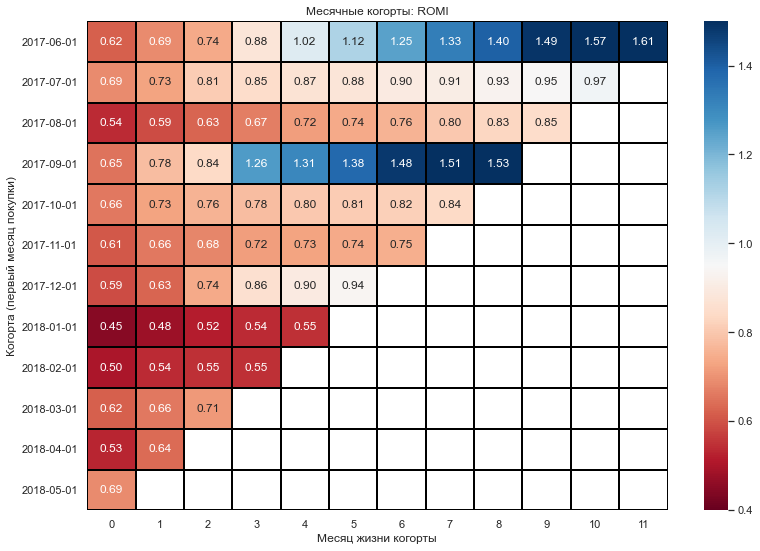

In [62]:
# Расчет ROMI
monthly_costs = costs.groupby('month_dt').agg({'costs': 'sum'})
report_all = pd.merge(cohorts_orders, monthly_costs, left_on='first_buy_month', right_on='month_dt')
report_all['cac'] = report_all['costs'] / report_all['n_buyers']
report_all['romi'] = report_all['rev_mean'] / report_all['cac']

output_romi = report_all.pivot_table(
    index='first_buy_month2', 
    columns='cohort_lifetime', 
    values='romi', 
    aggfunc='mean')
output_romi = output_romi.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Месячные когорты: ROMI')
sns.heatmap(output_romi, 
            annot=True, 
            fmt='.2f', 
            cmap="RdBu", 
            vmin=0.4, 
            vmax=1.5, 
            linewidths=1, 
            linecolor='black')
plt.xlabel('Месяц жизни когорты')
plt.yticks(rotation=0)
plt.ylabel('Когорта (первый месяц покупки)')
plt.show()

In [63]:
output_romi.mean(axis=0)

cohort_lifetime
0     0.596
1     0.648
2     0.698
3     0.790
4     0.863
5     0.944
6     0.993
7     1.078
8     1.173
9     1.097
10    1.270
11    1.610
dtype: float64

_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №1_______________________________


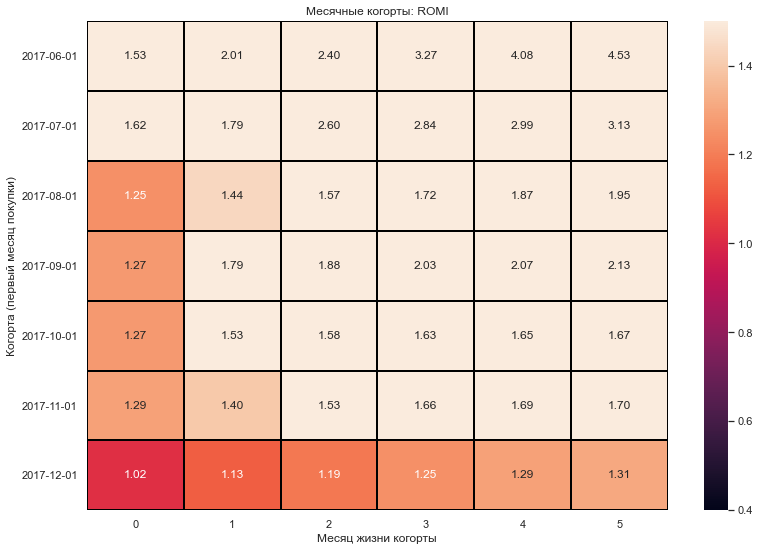

cohort_lifetime
0    1.321
1    1.584
2    1.821
3    2.057
4    2.234
5    2.346
dtype: float64
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №2_______________________________


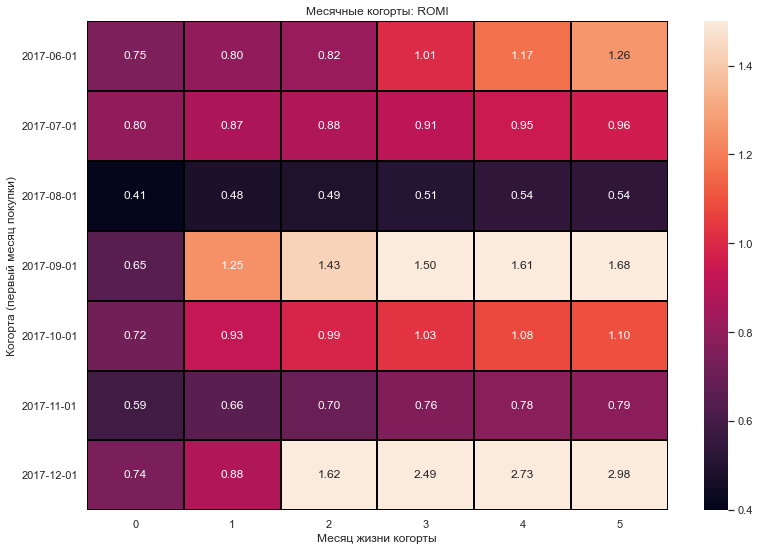

cohort_lifetime
0    0.666
1    0.839
2    0.990
3    1.173
4    1.266
5    1.330
dtype: float64
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №3_______________________________


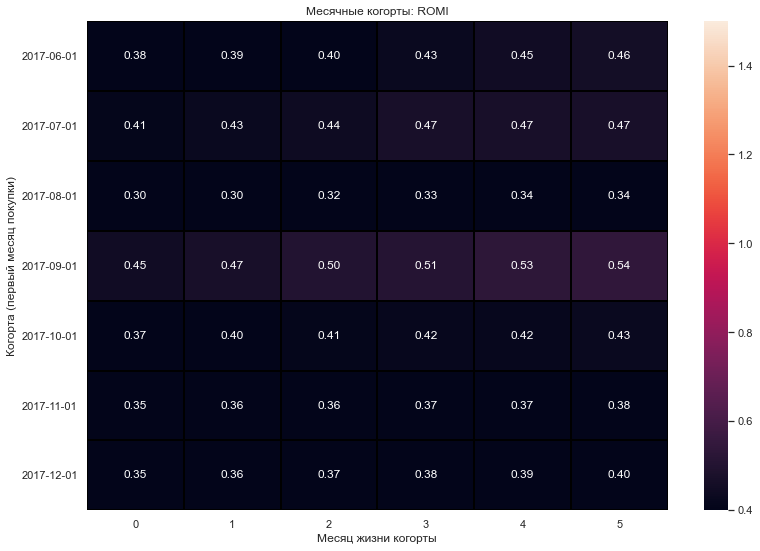

cohort_lifetime
0    0.373
1    0.387
2    0.400
3    0.416
4    0.424
5    0.431
dtype: float64
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №4_______________________________


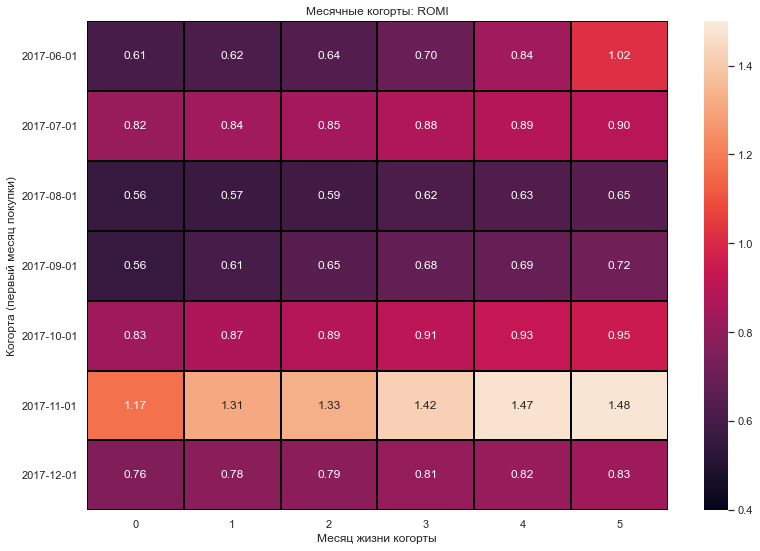

cohort_lifetime
0    0.759
1    0.800
2    0.820
3    0.860
4    0.896
5    0.936
dtype: float64
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №5_______________________________


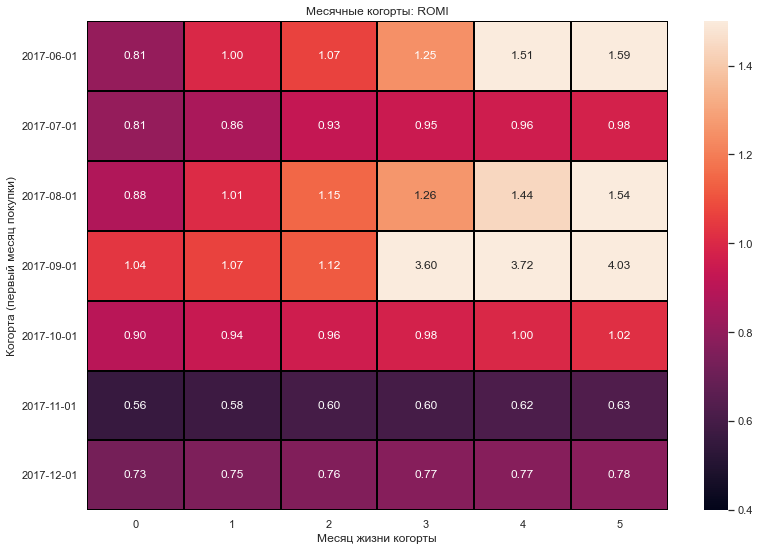

cohort_lifetime
0    0.819
1    0.887
2    0.941
3    1.344
4    1.431
5    1.510
dtype: float64
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №9_______________________________


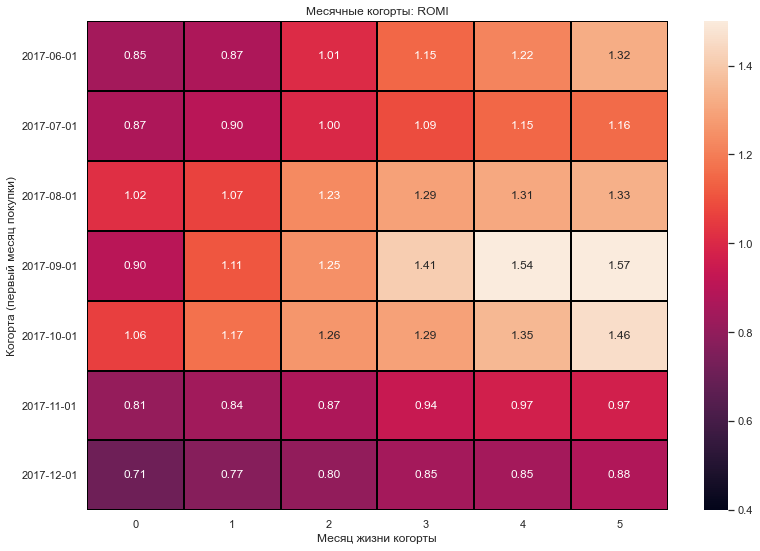

cohort_lifetime
0    0.889
1    0.961
2    1.060
3    1.146
4    1.199
5    1.241
dtype: float64
_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №10_______________________________


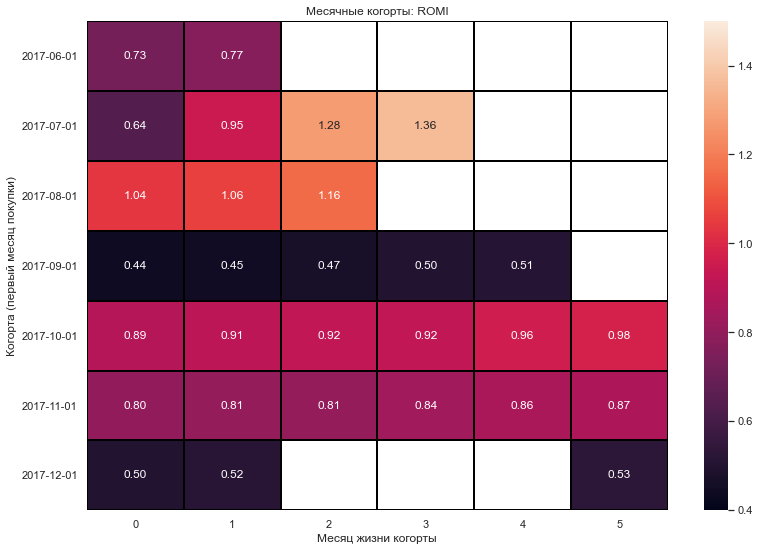

cohort_lifetime
0    0.720
1    0.781
2    0.928
3    0.905
4    0.777
5    0.793
dtype: float64


In [64]:
# Расчет ROMI по источникам
for source in costs['source_id'].unique():
    orders_sourse = orders[orders['source_id'] == source]
    print(f'_______________________________РЕКЛАМНЫЙ ИСТОЧНИК №{source}_______________________________')
    
    # Построение когорт
    coh = orders_sourse.groupby(['first_buy_month','buy_month']).agg({'revenue': 'sum'}).reset_index()
    coh_sizes = orders_sourse.groupby('first_buy_month').agg({'uid': 'nunique'}).reset_index()
    coh_sizes.columns = ['first_buy_month', 'n_buyers']
    coh = coh.merge(coh_sizes, on='first_buy_month')
    
    # Расчет «месяца жизни»
    coh['cohort_lifetime'] = (((coh['buy_month'] - coh['first_buy_month'])
                               / np.timedelta64(1, 'M'))
                              .round().astype('int'))
    # Расходы на источник
    costs_sourse = costs[costs['source_id'] == source]
    mon_costs = costs_sourse.groupby('month_dt').agg({'costs': 'sum'})
    coh = pd.merge(coh, mon_costs, left_on='first_buy_month', right_on='month_dt')
    coh = coh.query('first_buy_month < "2018-01-01" and cohort_lifetime < 6')
    
    # Расчет показателей
    coh['ltv'] = coh['revenue'] / coh['n_buyers']
    coh['cac'] = coh['costs'] / coh['n_buyers']
    coh['romi'] = coh['ltv'] / coh['cac']
    coh['first_buy_month2'] = coh['first_buy_month'].astype('str')
    
    output_sourse = coh.pivot_table(
        index='first_buy_month2', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')
    output_sourse = output_sourse.cumsum(axis=1).round(2)

    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title('Месячные когорты: ROMI')
    sns.heatmap(output_sourse, 
                annot=True, 
                fmt='.2f', 
                vmin=0.4, 
                vmax=1.5, 
                linewidths=1, 
                linecolor='black')
    plt.xlabel('Месяц жизни когорты')
    plt.yticks(rotation=0)
    plt.ylabel('Когорта (первый месяц покупки)')
    plt.show()
    
    # ROMI средней когорты
    print(output_sourse.mean(axis=0))

* Суммарно за год на маркетинг было потрачено около 329 тыс. Пик расходов, как и в случае суммарной выручки, достигается в ноябре - декабре. Наибольшие расходы идут на рекламный источник №3, более чем в 2 раза меньше - на №4. Наименее затратными являются девятый и десятый источники.
    
* Третий источник является самым затратным и по показателю стоимости привлечения одного покупателя (более 13 руб.). Наиболее выгодными, судя по данной метрике, являются первый, девятый и десятый источники. 
    
* Так как у нас в распоряжении имеются только данные по расходам на маркетинг, окупаемость рассчитывается по показателю ROMI (Return On Marketing Investment). За период исследования окупилось только 2 когорты (июньская и сентябрьская). Средняя когорта окупается только к 8 месяцу жизни.
    
* В то же время окупаемость существенно разнится по рекламным источникам. Так, расходы когорты пользователей, привлеченных из первого источника, окупаются уже на 2 месяц, из девятого источника - на 3, из пятого и второго - на 4 месяц. За полгода не окупились расходы по источникам №3, №4 и №10.


## 3. Выводы <a id="three"></a>

**Продукт**
    
* За исследуемый период количество уникальных пользователей в день в среднем составляло 907 человек, в неделю - 5,7 тыс. человек, в месяц - 23,2 тыс., при этом количество уникальных пользователей значительно возрастает с августа по ноябрь, что может быть связано с покупкой билетов на новогодние мероприятия.
    
* Как правило, для подключения к сервису пользователи чаще используют компьютер (количество уникальных пользователей в день, подключающихся посредством компьютера, в 2,5 раза превышает соответствующее значение для мобильных устройств).
    
* В среднем в день фиксируется 987 сессий, т.е. чуть более 1.08 сессии на одного уникального пользователя.
    
* Одна сессия длится в среднем 300 сек (или 5 минут), однако наибольшее число составляют сессии продолжительность 60 сек (1 минута). Стоит отметить, что продолжительность сессий с компьютеров, как правило, в 2 раза дольше, что с мобильных устройств.
    
* На второй месяц сервис теряет более 90% пользователей. Как правило, около 6-7% возвращаются на сервис к новому году (ближе к октябрю-ноябрю). Ближе к лету (в мае) коэффициент удержания падает почти во всех когорта, что может быть связано с началом сезона отпусков. 
    
* Больше всего уникальных пользователей привлекают рекламные источники №2, №3, №4 и №5. При этом пользователи из источников №1, №2, №9 и №4 чаще возвращаются на сервис.
    
**Продажи**    
    
* Около 16% посетителей совершают покупку. При этом первая покупка вне зависимости от месяца, как правило, совершается в день первого посещения. 
    
*   Подавляющее большинство пользователей совершает за год не более 1 покупки, при этом есть категория пользователей (12 пользователей), совершивших более 100 покупок.
    
* Суммарная выручка от покупок достигает пика к январю (36,3 тыс.руб.). Средняя же выручка сервиса с одной покупки относительно стабильна по месяцам и составляет 2,5 руб. 
    
* Для ответа на вопрос "Сколько пользователь приносит в среднем со всех своих покупок (LTV)" использован когортный анализ. С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. Для сравнимости в качестве "периода жизни" когорты было принято 6 месяцев (данный период позволяет отсечь при расчете не так много когорт). Так к концу 6 месяца пользователи когорт в среднем приносят 7,96 руб. Примечательно является сентябрьская когорта, где этот показатель достигает 12,3 руб.
    
* Средний чек покупателей, пользующихся компьютерами для доступа к сервису, на 0,25 руб. выше покупателей, пользующихся мобильными устройствами. LTV таких пользователей за 6 месяцев также, как правило, выше.
      
**Маркетинг**    
        
* Суммарно за год на маркетинг было потрачено около 329 тыс. Пик расходов, как и в случае суммарной выручки, достигается в ноябре - декабре. Наибольшие расходы идут на рекламный источник №3, более чем в 2 раза меньше - на №4. Наименее затратными являются девятый и десятый источники.
    
* Третий источник является самым затратным и по показателю стоимости привлечения одного покупателя (более 13 руб.). Наиболее выгодными, судя по данной метрике, являются первый, девятый и десятый источники. 
    
* Так как у нас в распоряжении имеются только данные по расходам на маркетинг, окупаемость рассчитывается по показателю ROMI (Return On Marketing Investment). За период исследования окупилось только 2 когорты (июньская и сентябрьская). Средняя когорта окупается только к 8 месяцу жизни.
    
* В то же время окупаемость существенно разнится по рекламным источникам. Так, расходы когорты пользователей, привлеченных из первого источника, окупаются уже на 2 месяц, из девятого источника - на 3, из пятого и второго - на 4 месяц. За полгода не окупились расходы по источникам №3, №4 и №10.
    
***Кажется целесообразным перенаправить большую часть расходов, идущих на рекламный источник №3, на первый и девятый источники. Так, сейчас именно на третий канал приходится наибольшая доля маркетинговых издержек, при этом он характеризуется как высокой стоимостью привлечения одного клиента, так и низкой окупаемостью.***
